In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
class Brats2021LSTMDatasetLazy(Dataset):
    def __init__(self, subject_files, temporal=4, train=True):
        """
        subject_files: list of paths to preprocessed .npz files,
                       each containing 'volume' and 'label' arrays.
        temporal: number of slices per temporal window (for training)
        train: whether this is a training set or not
        """
        self.subject_files = subject_files
        self.temporal = temporal
        self.is_train = train

        self.freq = np.zeros(5)
        self.data = []

        print('~' * 50)
        print('******** Loading data********')
        
        count = 0
        # First pass: compute frequency and determine slices/entries
        for file_path in self.subject_files:
            count += 1
            if count % 10 == 0:
                print('Processing subject %d/%d' % (count, len(self.subject_files)))
            
            volume, label = self._load_subject(file_path)
            self.freq += self._get_freq(label) # Store the label of each subject to get the distributon and then calculate weights
            
            if self.is_train:
                # Training: sample temporal windows
                img_starts = self._compute_training_slices(volume)
                for start in img_starts:
                    self.data.append((file_path, start))
            else:
                # Validation/test: store entire subject
                self.data.append((file_path, None))
        
        self.freq = self.freq / np.sum(self.freq)
        self.weight = np.median(self.freq) / (self.freq + 1e-8) # Median weight used, same as the one proposed in the original paper
        print('******** Finished setup ********')
        print('Number of entries in this split:', len(self.data))
        print('********  Temporal length is %d ********' % self.temporal)
        print('********  Weight for all classes  ********')
        print(self.weight)
        print('~' * 50)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        For training:
            We have (file_path, start_slice) and we load just that temporal window.
        For testing:
            We have (file_path, None) and we load the full subject.
        """
        file_path, start = self.data[index]
        volume, label = self._load_subject(file_path)

        if self.is_train:
            # Extract the temporal window
            images_vol, labels_vol, names = self._extract_window(volume, label, file_path, start)
        else:
            # Return full volume
            # volume: (4,D,H,W), label: (D,H,W)
            # For testing, we return (D,4,H,W)
            volume = volume.transpose(1,0,2,3)  # (D,4,H,W)
            images_vol = volume
            labels_vol = label
            names = [file_path]

        return images_vol, labels_vol, names

    def _load_subject(self, file_path):
        """
        Loads a subject from a .npz file.
        The .npz file must contain:
          volume: (4,D,H,W) preprocessed volume
          label:  (D,H,W) segmentation labels
        """
        data = np.load(file_path)
        volume = data['volume']  # (4,D,H,W)
        label = data['label']    # (D,H,W)
        return volume, label

    def _compute_training_slices(self, volume):
        """
        Determine where to sample temporal windows from.
        Similar logic as the original paper:
        Find non-zero start and end, then pick random windows.
        """
        D = volume.shape[1]
        H = volume.shape[2]
        W = volume.shape[3]

        zero_vol = np.zeros((4,H,W))
        no_zero_start = 0
        no_zero_end = D

        # We keep checking until we find a non-zero start and end, by non-zero start we mean a slice that doesn't contain only the background
        for i in range(D):
            if not np.all(volume[:, i, :, :] == zero_vol):
                no_zero_start = i
                break

        for i in range(no_zero_start, D):
            if np.all(volume[:, i, :, :] == zero_vol):
                no_zero_end = i
                break

        num_slices = no_zero_end - no_zero_start
        times = int(num_slices / self.temporal)
        # Random offset
        rand_start = no_zero_start + np.random.randint(-self.temporal//2, self.temporal//2 + 1)

        img_starts = []
        for t in range(times):
            start_idx = rand_start + t * self.temporal
            # Adjust start_idx if it goes out of range
            start_idx = max(start_idx, no_zero_start)
            if start_idx + self.temporal <= no_zero_end:
                img_starts.append(start_idx)

        return img_starts

    def _extract_window(self, volume, label, file_path, start):
        """
        Extract a temporal window starting at 'start', start is a list containing start locations.
        Returns (temporal,4,H,W) volume and (temporal,H,W) label.
        """
        tmp_im = []
        tmp_lbl = []
        tmp_name = []
        # extract slices from the depth starting at the determined spots in the last function
        for i in range(start, start + self.temporal):
            tmp_im.append(torch.from_numpy(volume[:, i, :, :]))   # (4,H,W)
            tmp_lbl.append(torch.from_numpy(label[i, :, :]))       # (H,W)
            tmp_name.append(file_path + '=slice' + str(i))

        tmp_im = torch.stack(tmp_im)   # (temporal,4,H,W)
        tmp_lbl = torch.stack(tmp_lbl) # (temporal,H,W)
        return tmp_im, tmp_lbl, tmp_name

    @staticmethod
    def _get_freq(label):
        """
        Calculate frequency of each class in the label.
        label: (D,H,W)
        """
        class_count = np.zeros((5))
        for i in range(5):
            class_count[i] = np.sum(label == i)
        return class_count


In [3]:
# Get all subject directories
data_dir = '/kaggle/input/brats2021-preprocessed/content/brats21-dataset-preprocessed'
all_subjects = [os.path.join(data_dir, s) for s in os.listdir(data_dir) 
                if s.endswith('.npz')]


np.random.seed(42)  # for reproducibility
np.random.shuffle(all_subjects)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total = len(all_subjects)
train_count = int(train_ratio * total)
val_count = int(val_ratio * total)

train_subjects = all_subjects[:train_count]
val_subjects = all_subjects[train_count:train_count+val_count]
test_subjects = all_subjects[train_count+val_count:]

In [4]:
# Create dataset objects for each split
train_dataset = Brats2021LSTMDatasetLazy(train_subjects, temporal=4, train=True)
val_dataset = Brats2021LSTMDatasetLazy(val_subjects, temporal=4, train=False)
test_dataset = Brats2021LSTMDatasetLazy(test_subjects, temporal=4, train=False)

# Wrap them in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, pin_memory = True, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory = True, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory = True, shuffle=False, num_workers=2)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
******** Loading data********
Processing subject 10/875
Processing subject 20/875
Processing subject 30/875
Processing subject 40/875
Processing subject 50/875
Processing subject 60/875
Processing subject 70/875
Processing subject 80/875
Processing subject 90/875
Processing subject 100/875
Processing subject 110/875
Processing subject 120/875
Processing subject 130/875
Processing subject 140/875
Processing subject 150/875
Processing subject 160/875
Processing subject 170/875
Processing subject 180/875
Processing subject 190/875
Processing subject 200/875
Processing subject 210/875
Processing subject 220/875
Processing subject 230/875
Processing subject 240/875
Processing subject 250/875
Processing subject 260/875
Processing subject 270/875
Processing subject 280/875
Processing subject 290/875
Processing subject 300/875
Processing subject 310/875
Processing subject 320/875
Processing subject 330/875
Processing subject 340/875
Processing

In [5]:
# Defining blocks
#ConvBlock2d
class ConvBlock2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock2d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# ConvTrans2d
class ConvTrans2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvTrans2d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv1(x)

#UpBlock2d
class UpBlock2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpBlock2d, self).__init__()
        self.up_conv = ConvTrans2d(in_ch, out_ch)
        self.conv = ConvBlock2d(2 * out_ch, out_ch)

    def forward(self, x, down_features):
        x = self.up_conv(x)  # Upsample
        x = torch.cat([x, down_features], dim=1)  # Concatenate with features from encoder
        x = self.conv(x)  # Apply convolutions
        return x

#MaxPool2d
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(MaxPool2d, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        return self.pool(x)

#ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, act_fn, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_dim),
            act_fn,
        )

    def forward(self, x):
        return self.conv(x)
        
def croppCenter(tensorToCrop,finalShape):
    org_shape = tensorToCrop.shape

    diff = np.zeros(2)
    diff[0] = org_shape[2] - finalShape[2]
    diff[1] = org_shape[3] - finalShape[3]

    croppBorders = np.zeros(2,dtype=int)
    croppBorders[0] = int(diff[0]/2)
    croppBorders[1] = int(diff[1]/2)

    return tensorToCrop[:, :,
                        croppBorders[0]:croppBorders[0] + finalShape[2],
                        croppBorders[1]:croppBorders[1] + finalShape[3]]

In [6]:
class MMUnet(nn.Module):
    """Multi-Modal-Unet"""
    def __init__(self, input_nc, output_nc=5, ngf=32):
        super(MMUnet, self).__init__()
        print('~' * 50)
        print(' ----- Creating MULTI_UNET  ...')
        print('~' * 50)

        self.in_dim = input_nc
        self.out_dim = ngf
        self.final_out_dim = output_nc

        # Define the max pooling operation using the provided MaxPool2d class
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)

        # ~~~ Encoding Paths ~~~~~~ #
        # Encoder (Modality 1)
        self.down_1_0 = ConvBlock2d(1, self.out_dim)
        self.pool_1_0 = self.maxpool
        self.down_2_0 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_0 = self.maxpool
        self.down_3_0 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_0 = self.maxpool
        self.down_4_0 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_0 = self.maxpool

        # Encoder (Modality 2)
        self.down_1_1 = ConvBlock2d(1, self.out_dim)
        self.pool_1_1 = self.maxpool
        self.down_2_1 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_1 = self.maxpool
        self.down_3_1 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_1 = self.maxpool
        self.down_4_1 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_1 = self.maxpool

        # Encoder (Modality 3)
        self.down_1_2 = ConvBlock2d(1, self.out_dim)
        self.pool_1_2 = self.maxpool
        self.down_2_2 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_2 = self.maxpool
        self.down_3_2 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_2 = self.maxpool
        self.down_4_2 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_2 = self.maxpool

        # Encoder (Modality 4)
        self.down_1_3 = ConvBlock2d(1, self.out_dim)
        self.pool_1_3 = self.maxpool
        self.down_2_3 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_3 = self.maxpool
        self.down_3_3 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_3 = self.maxpool
        self.down_4_3 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_3 = self.maxpool

        # Bridge
        self.bridge = ConvBlock2d(self.out_dim * 60, self.out_dim * 16)

        # ~~~ Decoding Path ~~~~~~ #
        self.upLayer1 = UpBlock2d(self.out_dim * 16, self.out_dim * 8)
        self.upLayer2 = UpBlock2d(self.out_dim * 8, self.out_dim * 4)
        self.upLayer3 = UpBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.upLayer4 = UpBlock2d(self.out_dim * 2, self.out_dim * 1)

    def forward(self, input):
        # Split input by modality
        i0 = input[:, 0:1, :, :]
        i1 = input[:, 1:2, :, :]
        i2 = input[:, 2:3, :, :]
        i3 = input[:, 3:4, :, :]

        # First level
        down_1_0 = self.down_1_0(i0)
        down_1_1 = self.down_1_1(i1)
        down_1_2 = self.down_1_2(i2)
        down_1_3 = self.down_1_3(i3)

        # Second level inputs
        input_2nd_0 = torch.cat((self.pool_1_0(down_1_0),
                                 self.pool_1_1(down_1_1),
                                 self.pool_1_2(down_1_2),
                                 self.pool_1_3(down_1_3)), dim=1)

        input_2nd_1 = torch.cat((self.pool_1_1(down_1_1),
                                 self.pool_1_2(down_1_2),
                                 self.pool_1_3(down_1_3),
                                 self.pool_1_0(down_1_0)), dim=1)

        input_2nd_2 = torch.cat((self.pool_1_2(down_1_2),
                                 self.pool_1_3(down_1_3),
                                 self.pool_1_0(down_1_0),
                                 self.pool_1_1(down_1_1)), dim=1)

        input_2nd_3 = torch.cat((self.pool_1_3(down_1_3),
                                 self.pool_1_0(down_1_0),
                                 self.pool_1_1(down_1_1),
                                 self.pool_1_2(down_1_2)), dim=1)

        down_2_0 = self.down_2_0(input_2nd_0)
        down_2_1 = self.down_2_1(input_2nd_1)
        down_2_2 = self.down_2_2(input_2nd_2)
        down_2_3 = self.down_2_3(input_2nd_3)

        # Third level inputs
        down_2_0m = self.pool_2_0(down_2_0)
        down_2_1m = self.pool_2_1(down_2_1)
        down_2_2m = self.pool_2_2(down_2_2)
        down_2_3m = self.pool_2_3(down_2_3)

        input_3rd_0 = torch.cat((down_2_0m, down_2_1m, down_2_2m, down_2_3m), dim=1)
        input_3rd_0 = torch.cat((input_3rd_0, croppCenter(input_2nd_0, input_3rd_0.shape)), dim=1)

        input_3rd_1 = torch.cat((down_2_1m, down_2_2m, down_2_3m, down_2_0m), dim=1)
        input_3rd_1 = torch.cat((input_3rd_1, croppCenter(input_2nd_1, input_3rd_1.shape)), dim=1)

        input_3rd_2 = torch.cat((down_2_2m, down_2_3m, down_2_0m, down_2_1m), dim=1)
        input_3rd_2 = torch.cat((input_3rd_2, croppCenter(input_2nd_2, input_3rd_2.shape)), dim=1)

        input_3rd_3 = torch.cat((down_2_3m, down_2_0m, down_2_1m, down_2_2m), dim=1)
        input_3rd_3 = torch.cat((input_3rd_3, croppCenter(input_2nd_3, input_3rd_3.shape)), dim=1)

        down_3_0 = self.down_3_0(input_3rd_0)
        down_3_1 = self.down_3_1(input_3rd_1)
        down_3_2 = self.down_3_2(input_3rd_2)
        down_3_3 = self.down_3_3(input_3rd_3)

        # Fourth level inputs
        down_3_0m = self.pool_3_0(down_3_0)
        down_3_1m = self.pool_3_1(down_3_1)
        down_3_2m = self.pool_3_2(down_3_2)
        down_3_3m = self.pool_3_3(down_3_3)

        input_4th_0 = torch.cat((down_3_0m, down_3_1m, down_3_2m, down_3_3m), dim=1)
        input_4th_0 = torch.cat((input_4th_0, croppCenter(input_3rd_0, input_4th_0.shape)), dim=1)

        input_4th_1 = torch.cat((down_3_1m, down_3_2m, down_3_3m, down_3_0m), dim=1)
        input_4th_1 = torch.cat((input_4th_1, croppCenter(input_3rd_1, input_4th_1.shape)), dim=1)

        input_4th_2 = torch.cat((down_3_2m, down_3_3m, down_3_0m, down_3_1m), dim=1)
        input_4th_2 = torch.cat((input_4th_2, croppCenter(input_3rd_2, input_4th_2.shape)), dim=1)

        input_4th_3 = torch.cat((down_3_3m, down_3_0m, down_3_1m, down_3_2m), dim=1)
        input_4th_3 = torch.cat((input_4th_3, croppCenter(input_3rd_3, input_4th_3.shape)), dim=1)

        down_4_0 = self.down_4_0(input_4th_0)
        down_4_1 = self.down_4_1(input_4th_1)
        down_4_2 = self.down_4_2(input_4th_2)
        down_4_3 = self.down_4_3(input_4th_3)

        # Bridge
        down_4_0m = self.pool_4_0(down_4_0)
        down_4_1m = self.pool_4_1(down_4_1)
        down_4_2m = self.pool_4_2(down_4_2)
        down_4_3m = self.pool_4_3(down_4_3)

        inputBridge = torch.cat((down_4_0m, down_4_1m, down_4_2m, down_4_3m), dim=1)
        inputBridge = torch.cat((inputBridge, croppCenter(input_4th_0, inputBridge.shape)), dim=1)

        bridge = self.bridge(inputBridge)

        # Decoding path
        skip_1 = (down_4_0 + down_4_1 + down_4_2 + down_4_3) / 4.0
        skip_2 = (down_3_0 + down_3_1 + down_3_2 + down_3_3) / 4.0
        skip_3 = (down_2_0 + down_2_1 + down_2_2 + down_2_3) / 4.0
        skip_4 = (down_1_0 + down_1_1 + down_1_2 + down_1_3) / 4.0

        x = self.upLayer1(bridge, skip_1)
        x = self.upLayer2(x, skip_2)
        x = self.upLayer3(x, skip_3)
        x = self.upLayer4(x, skip_4)

        return x


class LSTM0(nn.Module):
    def __init__(self, in_c=5, ngf=32):
        super(LSTM0, self).__init__()
        # Using ConvBlock with Identity activation to emulate linear conv
        identity = nn.Identity()
        self.conv_gx_lstm0 = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_ix_lstm0 = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_ox_lstm0 = ConvBlock(in_c + ngf, ngf, identity)

    def forward(self, xt):
        # xt: bz * (5 + 32) * H * W
        gx = torch.tanh(self.conv_gx_lstm0(xt))
        ix = torch.sigmoid(self.conv_ix_lstm0(xt))
        ox = torch.sigmoid(self.conv_ox_lstm0(xt))

        cell_1 = torch.tanh(gx * ix)
        hide_1 = ox * cell_1
        return cell_1, hide_1


class LSTM(nn.Module):
    def __init__(self, in_c=5, ngf=32):
        super(LSTM, self).__init__()
        identity = nn.Identity()
        
        # For LSTM we have pairs of conv: one on xt and one on hide_t_1.
        # We'll create two ConvBlock layers and sum their outputs.
        # We'll store them as (conv_ix_lstm, conv_ih_lstm, ...) using ConvBlock:
        
        self.conv_ix_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_ih_lstm = ConvBlock(ngf, ngf, identity)

        self.conv_fx_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_fh_lstm = ConvBlock(ngf, ngf, identity)

        self.conv_ox_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_oh_lstm = ConvBlock(ngf, ngf, identity)

        self.conv_gx_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_gh_lstm = ConvBlock(ngf, ngf, identity)

    def forward(self, xt, cell_t_1, hide_t_1):
        gx = self.conv_gx_lstm(xt)
        gh = self.conv_gh_lstm(hide_t_1)
        g_sum = gx + gh
        gt = torch.tanh(g_sum)

        ox = self.conv_ox_lstm(xt)
        oh = self.conv_oh_lstm(hide_t_1)
        o_sum = ox + oh
        ot = torch.sigmoid(o_sum)

        ix = self.conv_ix_lstm(xt)
        ih = self.conv_ih_lstm(hide_t_1)
        i_sum = ix + ih
        it = torch.sigmoid(i_sum)

        fx = self.conv_fx_lstm(xt)
        fh = self.conv_fh_lstm(hide_t_1)
        f_sum = fx + fh
        ft = torch.sigmoid(f_sum)

        cell_t = ft * cell_t_1 + it * gt
        hide_t = ot * torch.tanh(cell_t)

        return cell_t, hide_t


class LSTM_MMUnet(nn.Module):
    def __init__(self, input_nc=1, output_nc=5, ngf=32, temporal=3):
        super(LSTM_MMUnet, self).__init__()
        self.temporal = temporal
        self.mmunet = MMUnet(input_nc, output_nc, ngf)
        self.lstm0 = LSTM0(in_c=output_nc, ngf=ngf)
        self.lstm = LSTM(in_c=output_nc, ngf=ngf)

        # Using ConvBlock to replace direct Conv2d layers for output
        # For the output convolution, we can still use ConvBlock with Identity and then a final activation outside if needed.
        identity = nn.Identity()

        # mmout and out: originally were Conv2d. Now replaced with ConvBlock followed by extracting just conv from it.
        # However, we must produce final output without BN/activation. Let's just use ConvBlock and note that it introduces BN.
        # If strictly needed linear: we can add Identity after block and rely on user's acceptance of BN here.
        self.mmout_block = ConvBlock(ngf, output_nc, identity)
        self.out_block = ConvBlock(ngf, output_nc, identity)

    def forward(self, x):
        """
        :param x: bz * temporal * 4 * H * W
        """
        output = []
        mm_output = []
        cell = None
        hide = None
        for t in range(self.temporal):
            im_t = x[:, t, :, :, :]
            mm_last = self.mmunet(im_t)        # bz * ngf(32) * H * W
            out_t_mm = self.mmout_block(mm_last)  # bz * output_nc(5) * H * W
            mm_output.append(out_t_mm)

            lstm_in = torch.cat((out_t_mm, mm_last), dim=1) # bz * (5+32) * H * W

            if t == 0:
                cell, hide = self.lstm0(lstm_in)
            else:
                cell, hide = self.lstm(lstm_in, cell, hide)

            out_t = self.out_block(hide)
            output.append(out_t)

        return torch.stack(mm_output, dim=1), torch.stack(output, dim=1)


In [7]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, loss, and optimizer
model = LSTM_MMUnet(input_nc=1, output_nc=5, ngf=32, temporal=4).to(device)

weight = torch.from_numpy(train_dataset.weight).float()    # weight for all classes 
weight = weight.to(device)
criterion = nn.CrossEntropyLoss(weight = weight)  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# The model was largely trained in parts. We save the models state after each epoch and use it at the start of the new cycle
# This was done as we had computational limits and each epoch takes approximately 2.5 hours
checkpoint_path = '/kaggle/input/lstm_epoch4/pytorch/default/1/checkpoint_epoch_4.pth' 

start_epoch = 0
if os.path.exists(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # resume from next epoch
    print(f"Resuming training from epoch {start_epoch}")

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (images, labels, names) in enumerate(train_loader):
        if(batch_idx%100 == 0):
            print(f"\tProcessing batch {batch_idx + 1}/{len(train_loader)}")
        # images: (B, temporal, 4, H, W)
        # labels: (B, temporal, H, W)
        images = images.to(device)  # (B, T, 4, H, W)
        labels = labels.to(device)  # (B, T, H, W)

        optimizer.zero_grad()

        mm_output, output = model(images)  
        # output: (B, T, 5, H, W), labels: (B, T, H, W)

        # Rearrange or pick the appropriate dimension for loss
        # CrossEntropyLoss expects (N, C, ...) and label as (N, ...)
        # Here, N can be B*T because we have temporal dimension as well.
        B, T, C, H, W = output.shape
        output_flat = output.view(B*T, C, H, W)   # (B*T, 5, H, W)
        labels_flat = labels.view(B*T, H, W)      # (B*T, H, W)

        loss = criterion(output_flat, labels_flat)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss
    }, f'checkpoint_epoch_{epoch}.pth')
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    temporal = 4
    with torch.no_grad():
        for batch_idx, (images, labels, names) in enumerate(val_loader):
            for t in range(0, 155 - temporal, temporal):
                image = images[:, t:t+temporal, ...]  # 5D  bs * temp * 4 * 240 * 240
                label = labels[:, t:t+temporal, ...]       # 4D tensor   bs * temporal * 240 * 240
                image = image.to(device)
                label = label.to(device)
    
                mm_output, output = model(image)
                B, T, C, H, W = output.shape
                output_flat = output.view(B*T, C, H, W)
                labels_flat = label.view(B*T, H, W)
    
                loss = criterion(output_flat, labels_flat)
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 ----- Creating MULTI_UNET  ...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/tmp/ipykernel_23/2256405063.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Resuming training from epoch 5
	Processing batch 1/8313
	Processing batch 101/8313
	Processing batch 201/8313
	Processing batch 301/8313
	Processing batch 401/8313
	Processing batch 501/8313
	Processing batch 601/8313
	Processing batch 701/8313
	Processing batch 801/8313
	Processing batch 901/8313
	Processing batch 1001/8313
	Processing batch 1101/8313
	Processing batch 1201/8313
	Processing batch 1301/8313
	Processing batch 1401/8313
	Processing batch 1501/8313
	Processing batch 1601/8313
	Processing batch 1701/8313
	Processing batch 1801/8313
	Processing batch 1901/8313
	Processing batch 2001/8313
	Processing batch 2101/8313
	Processing batch 2201/8313
	Processing batch 2301/8313
	Processing batch 2401/8313
	Processing batch 2501/8313
	Processing batch 2601/8313
	Processing batch 2701/8313
	Processing batch 2801/8313
	Processing batch 2901/8313
	Processing batch 3001/8313
	Processing batch 3101/8313
	Processing batch 3201/8313
	Processing batch 3301/8313
	Processing batch 3401/8313
	

KeyboardInterrupt: 

In [8]:
from torchinfo import summary
summary(model, (4,4,4, 240, 240))

Layer (type:depth-idx)                             Output Shape              Param #
LSTM_MMUnet                                        [4, 4, 5, 240, 240]       --
├─MMUnet: 1-1                                      [4, 32, 240, 240]         --
│    └─ConvBlock2d: 2-1                            [4, 32, 240, 240]         --
│    │    └─Sequential: 3-1                        [4, 32, 240, 240]         384
│    │    └─Sequential: 3-2                        [4, 32, 240, 240]         9,312
│    └─ConvBlock2d: 2-2                            [4, 32, 240, 240]         --
│    │    └─Sequential: 3-3                        [4, 32, 240, 240]         384
│    │    └─Sequential: 3-4                        [4, 32, 240, 240]         9,312
│    └─ConvBlock2d: 2-3                            [4, 32, 240, 240]         --
│    │    └─Sequential: 3-5                        [4, 32, 240, 240]         384
│    │    └─Sequential: 3-6                        [4, 32, 240, 240]         9,312
│    └─ConvBlock2d: 2-4

In [16]:
def compute_metrics(preds, labels):
    """
    Compute accuracy, dice, F-score, sensitivity, precision, specificity, and IoU for multi-class segmentation.
    preds: (N, H, W) or (B,T,H,W) predicted labels
    labels: same shape as preds with ground truth labels
    """

    # Ensure preds and labels are CPU numpy arrays for easy manipulation
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    # shape could be (B,T,H,W). Let's combine B and T as one dimension:
    if preds.ndim == 4:
        # (B,T,H,W) => (B*T,H,W)
        BTHW = preds.shape[0]*preds.shape[1]
        preds = preds.reshape(BTHW, preds.shape[2], preds.shape[3])
        labels = labels.reshape(BTHW, labels.shape[2], labels.shape[3])
    else:
        BTHW = preds.shape[0]
    # Now preds and labels are (N,H,W)

    total_voxels = np.prod(preds.shape)
    accuracy = (preds == labels).sum() / total_voxels

    # Compute metrics per class
    dice_scores = []
    f_scores = []
    sensitivity_scores = []
    precision_scores = []
    specificity_scores = []
    iou_scores = []

    dice_per_class = {}
    f1_per_class = {}
    sensitivity_per_class = {}
    precision_per_class = {}
    specificity_per_class = {}
    iou_per_class = {}

    for c in [0,1,2,4]:
        pred_c = (preds == c)
        label_c = (labels == c)

        # intersection = TP
        intersection = np.logical_and(pred_c, label_c).sum()
        pred_c_sum = pred_c.sum()
        label_c_sum = label_c.sum()
        
        # TP, FP, FN, TN
        TP = intersection
        FP = pred_c_sum - intersection
        FN = label_c_sum - intersection
        TN = total_voxels - (TP + FP + FN)

        # Dice = (2 * TP) / (2 * TP + FP + FN)
        if pred_c_sum + label_c_sum > 0:
            dice_c = (2.0 * TP) / (pred_c_sum + label_c_sum)
        else:
            dice_c = 1.0 if pred_c_sum == 0 and label_c_sum == 0 else 0.0

        # F1 Score is the same as Dice for binary classification
        f1_c = dice_c

        # Sensitivity (Recall) = TP / (TP + FN)
        if (TP + FN) > 0:
            sensitivity_c = TP / (TP + FN)
        else:
            sensitivity_c = 0.0

        # Precision = TP / (TP + FP)
        if (TP + FP) > 0:
            precision_c = TP / (TP + FP)
        else:
            precision_c = 0.0

        # Specificity = TN / (TN + FP)
        if (TN + FP) > 0:
            specificity_c = TN / (TN + FP)
        else:
            specificity_c = 0.0

        # IoU = TP / (TP + FP + FN)
        denominator = TP + FP + FN
        if denominator > 0:
            iou_c = TP / denominator
        else:
            iou_c = 1.0 if TP == 0 and FP == 0 and FN == 0 else 0.0

        # Store metrics
        dice_scores.append(dice_c)
        f_scores.append(f1_c)
        sensitivity_scores.append(sensitivity_c)
        precision_scores.append(precision_c)
        specificity_scores.append(specificity_c)
        iou_scores.append(iou_c)

        dice_per_class[c] = dice_c
        f1_per_class[c] = f1_c
        sensitivity_per_class[c] = sensitivity_c
        precision_per_class[c] = precision_c
        specificity_per_class[c] = specificity_c
        iou_per_class[c] = iou_c

    # Compute averages over classes
    dice_avg = np.mean(dice_scores)
    f1_avg = np.mean(f_scores)
    sensitivity_avg = np.mean(sensitivity_scores)
    precision_avg = np.mean(precision_scores)
    specificity_avg = np.mean(specificity_scores)
    iou_avg = np.mean(iou_scores)

    return (accuracy, dice_avg, f1_avg, sensitivity_avg, precision_avg, specificity_avg, iou_avg,
            dice_per_class, f1_per_class, sensitivity_per_class, precision_per_class, specificity_per_class, iou_per_class)

# Test Loop
model.eval()
test_loss = 0.0
test_acc = 0.0
test_dice = 0.0
test_f1 = 0.0
test_sensitivity = 0.0
test_precision = 0.0
test_specificity = 0.0
test_iou = 0.0
count = 0

# To accumulate per-class metrics
classes = [0,1,2,4]

# Initialize per-class metric sums
dice_per_class_sum = {c:0.0 for c in classes}
f1_per_class_sum = {c:0.0 for c in classes}
sensitivity_per_class_sum = {c:0.0 for c in classes}
precision_per_class_sum = {c:0.0 for c in classes}
specificity_per_class_sum = {c:0.0 for c in classes}
iou_per_class_sum = {c:0.0 for c in classes}

temporal = 4

with torch.no_grad():
    for batch_idx, (images, labels, names) in enumerate(test_loader):
        
        for t in range(0, 155 - temporal, temporal):
            image = images[:, t:t+temporal, ...]  # 5D tensor bs * temp * 4 * H * W
            label = labels[:, t:t+temporal, ...]  # 4D tensor bs * temp * H * W
            image = image.to(device)
            label = label.to(device)

            mm_output, output = model(image)
            B, T, C, H, W = output.shape
            output_flat = output.view(B*T, C, H, W)
            labels_flat = label.view(B*T, H, W)
            
            loss = criterion(output_flat, labels_flat)
            test_loss += loss.item()

            predictions = torch.argmax(output_flat, dim=1)  # (B*T,H,W)
            predictions = predictions.view(B, T, H, W)
            labs = labels_flat.view(B, T, H, W)

            metrics = compute_metrics(predictions, labs)
            (acc, dice_avg, f1_avg, sensitivity_avg, precision_avg, specificity_avg, iou_avg,
             dice_per_class, f1_per_class, sensitivity_per_class, precision_per_class, specificity_per_class, iou_per_class) = metrics

            test_acc += acc
            test_dice += dice_avg
            test_f1 += f1_avg
            test_sensitivity += sensitivity_avg
            test_precision += precision_avg
            test_specificity += specificity_avg
            test_iou += iou_avg

            # Accumulate per-class metrics
            for c in classes:
                dice_per_class_sum[c] += dice_per_class[c]
                f1_per_class_sum[c] += f1_per_class[c]
                sensitivity_per_class_sum[c] += sensitivity_per_class[c]
                precision_per_class_sum[c] += precision_per_class[c]
                specificity_per_class_sum[c] += specificity_per_class[c]
                iou_per_class_sum[c] += iou_per_class[c]

            count += 1

# Compute averages
test_loss /= len(test_loader)
test_acc /= count
test_dice /= count
test_f1 /= count
test_sensitivity /= count
test_precision /= count
test_specificity /= count
test_iou /= count

dice_per_class_avg = {c: dice_per_class_sum[c]/count for c in classes}
f1_per_class_avg = {c: f1_per_class_sum[c]/count for c in classes}
sensitivity_per_class_avg = {c: sensitivity_per_class_sum[c]/count for c in classes}
precision_per_class_avg = {c: precision_per_class_sum[c]/count for c in classes}
specificity_per_class_avg = {c: specificity_per_class_sum[c]/count for c in classes}
iou_per_class_avg = {c: iou_per_class_sum[c]/count for c in classes}

# Print overall metrics
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, Dice: {test_dice:.4f}, F1: {test_f1:.4f}")
print(f"Sensitivity: {test_sensitivity:.4f}, Precision: {test_precision:.4f}, Specificity: {test_specificity:.4f}, IoU: {test_iou:.4f}")

# Print per-class metrics
print("\nPer-class metrics:")
for c in classes:
    print(f"Class {c}:")
    print(f"    Dice: {dice_per_class_avg[c]:.4f}")
    print(f"    F1 Score: {f1_per_class_avg[c]:.4f}")
    print(f"    Sensitivity: {sensitivity_per_class_avg[c]:.4f}")
    print(f"    Precision: {precision_per_class_avg[c]:.4f}")
    print(f"    Specificity: {specificity_per_class_avg[c]:.4f}")
    print(f"    IoU: {iou_per_class_avg[c]:.4f}")

Test Loss: 6.1886, Acc: 0.9928, Dice: 0.6786, F1: 0.6786
Sensitivity: 0.6113, Precision: 0.5067, Specificity: 0.9045, IoU: 0.6258

Per-class metrics:
Class 0:
    Dice: 0.9967
    F1 Score: 0.9967
    Sensitivity: 0.9937
    Precision: 0.9997
    Specificity: 0.6249
    IoU: 0.9935
Class 1:
    Dice: 0.6434
    F1 Score: 0.6434
    Sensitivity: 0.4029
    Precision: 0.3088
    Specificity: 0.9993
    IoU: 0.5907
Class 2:
    Dice: 0.5049
    F1 Score: 0.5049
    Sensitivity: 0.5623
    Precision: 0.3257
    Specificity: 0.9945
    IoU: 0.4107
Class 4:
    Dice: 0.5693
    F1 Score: 0.5693
    Sensitivity: 0.4861
    Precision: 0.3924
    Specificity: 0.9992
    IoU: 0.5081


In [11]:
with torch.no_grad():
    for batch_idx, (images, labels, names) in enumerate(test_loader):
        if batch_idx == 1:
            image = images[:, 70:70+temporal, ...]  
            label = labels[:, 70:70+temporal, ...]  
            image = image.to(device)
            label = label.to(device)

            _, output = model(image) 
            preds = torch.argmax(output, dim=2)  # Predicted mask
            break  # Visualize just one batch


In [13]:
image_np = image.cpu().numpy()  # Input image
label_np = label.cpu().numpy()  # Ground truth
preds_np = preds.cpu().numpy()  # Predicted mask

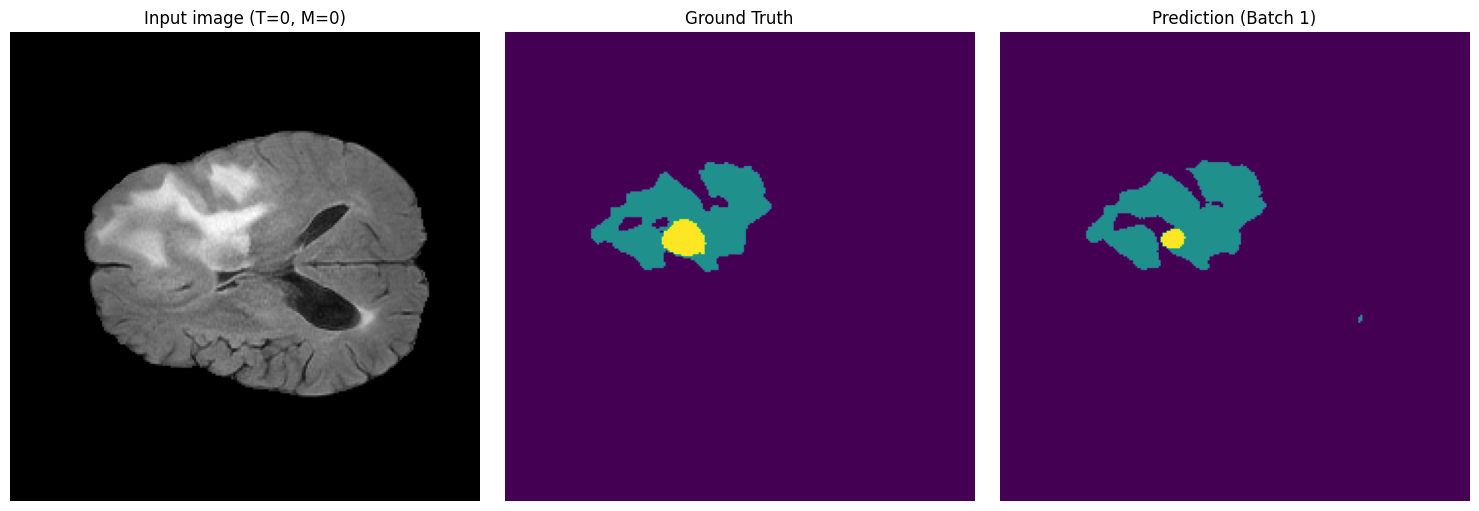

In [14]:
batch_idx = 1
temporal_idx = 0  
modal_idx = 0 
specific_image = image_np[batch_idx, temporal_idx, modal_idx]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Specific Temporal Slice and Channel
axes[0].imshow(specific_image, cmap='gray')
axes[0].set_title(f'Input image (T={temporal_idx}, M={modal_idx})')

# Ground Truth and Prediction 
axes[1].imshow(label_np[batch_idx, temporal_idx], cmap='viridis')
axes[1].set_title('Ground Truth')

# Visualize Predictions 
axes[2].imshow(preds_np[batch_idx, 0], cmap='viridis')  # First temporal slice of predictions
axes[2].set_title(f'Prediction (Batch {batch_idx})')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


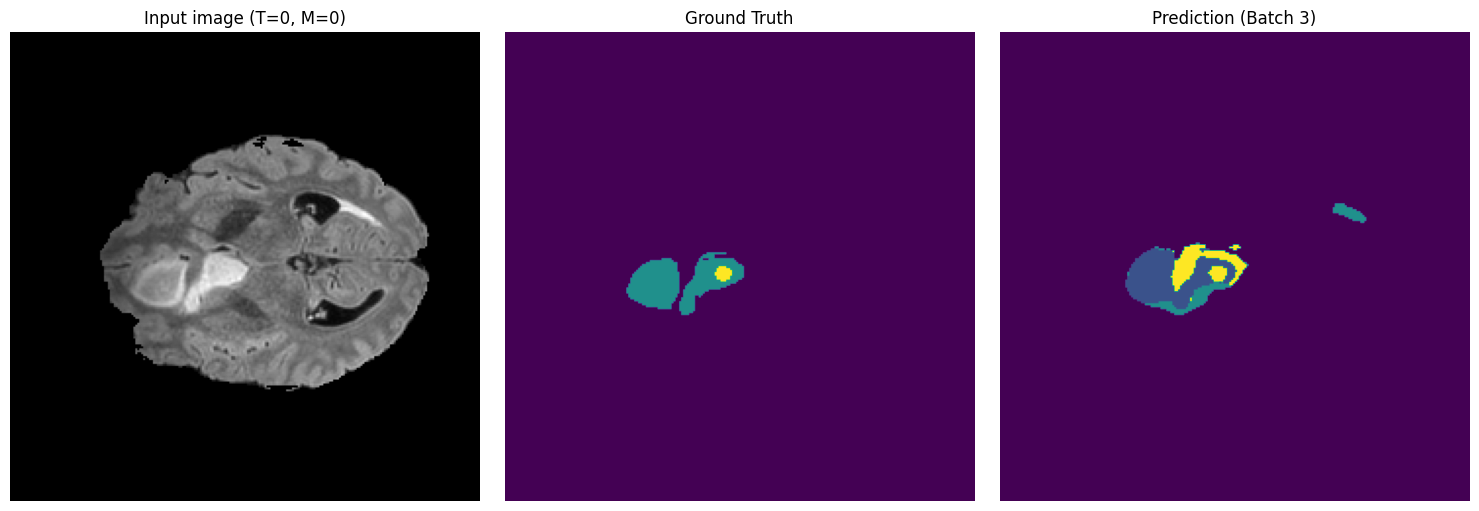

In [15]:
# Select a batch
batch_idx = 3
temporal_idx = 0  # Choose a specific temporal slice
modal_idx = 0  # Choose a specific modality
specific_image = image_np[batch_idx, temporal_idx, modal_idx]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Specific Temporal Slice and Channel
axes[0].imshow(specific_image, cmap='gray')
axes[0].set_title(f'Input image (T={temporal_idx}, M={modal_idx})')

# Ground Truth and Prediction 
axes[1].imshow(label_np[batch_idx, temporal_idx], cmap='viridis')
axes[1].set_title('Ground Truth')

# Visualize Predictions 
axes[2].imshow(preds_np[batch_idx, 0], cmap='viridis')  # First temporal slice of predictions
axes[2].set_title(f'Prediction (Batch {batch_idx})')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()